# Notebook Processo Seletivo Aluno Especial IA-024 1S2024 FEEC-UNICAMP
versão 5 de fevereiro de 2024, 19h
versão 8 de fevereiro de 2024, 20h - ajuste variável vocab_size

In [1]:
# This notebook was based on the given notebook by professor Roberto.
# It suffered many alteration throughout the development of the project.
# This is it's final form, please read the report about it's development
# to see all the history.

# Author: Rian Radeck
# Academic Register (RA): 187793

# Please uncomment these lines to install dependencies.
# !pip install torchtext
# !pip install 'portalocker>=2.0.0'
# !pip install matplotlib
# !pip install unidecode
# !pip install nltk

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.datasets import IMDB
from collections import Counter
import torch.nn as nn
import torch.optim as optim
import numpy as np

## I - Vocabulário e Tokenização

In [3]:
# This cell is responsible to process strings for the tokenizer.

# Treating strings, generated by GPT 3.5-turbo

import string
import unicodedata
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

def remove_accents(input_str):
    # Remove accents from characters
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return "".join([c for c in nfkd_form if not unicodedata.combining(c)])

def remove_punctuation(input_str):
    # Remove punctuation using string.punctuation
    translator = str.maketrans('', '', string.punctuation)
    return input_str.translate(translator)

def remove_stopwords(input_str, remove_stopwords_flag=False):
    # Remove English stopwords using NLTK
    if remove_stopwords_flag:
        english_stopwords = set(stopwords.words('english'))
        words = input_str.split()
        filtered_words = [word for word in words if word.lower() not in english_stopwords]
        return ' '.join(filtered_words)
    else:
        return input_str

def preprocess_text(text, remove_stopwords_flag=False):
    # Combine all preprocessing steps
    text = remove_accents(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text, remove_stopwords_flag)
    return text.lower()

# Example usage:
input_text = "Héllo, thïs is a tést! It includes accents and punctuation. Also, it has English stopwords."
preprocessed_text = preprocess_text(input_text, remove_stopwords_flag=True)
print("Preprocessed text:", preprocessed_text)


Preprocessed text: hello test includes accents punctuation also english stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rianr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# This cell is responsible for the generation of the vocabulary
# that will be used throughout the notebook.
# Here you will find the main parameters of the vocabulary construction.
# Please pay attention to the reduce_dataset flag and the vocab_size variable.

# limit the vocabulary size to 20000 most frequent tokens
vocab_size = 20000

# Initialize a Counter object to count occurrences of individual words
counter = Counter()

# Initialize a Counter object to count occurrences of labels (e.g., positive/negative sentiment)
label_counter = Counter()

# Initialize a variable to keep track of the total number of words in the dataset
total_words = 0

# Reduce dataset if needed
reduce_dataset = False

# This will be the number of train and test samples used.
reduced_dataset_size = 1000

dataset_train = list(IMDB(split='train')).copy()
for i in range(len(dataset_train)):
    dataset_train[i] = dataset_train[i][0], preprocess_text(dataset_train[i][1], False)
if reduce_dataset:
    np.random.shuffle(dataset_train)
    dataset_train = dataset_train[:reduced_dataset_size]

# Iterate over each review in the training set obtained from the IMDB dataset
for (label, line) in dataset_train:
    # Split the review text into individual words
    words_in_line = line.split()

    # Update the total number of words by adding the number of words in the current review
    total_words += len(words_in_line)

    # Update the Counter object with the individual words in the current review
    counter.update(words_in_line)

    # Update the Counter object with the label of the current review
    label_counter.update([label])

# Count the total number of reviews in the training set
number_of_reviews = len(dataset_train)

# Calculate the average number of words per review
avg_words_in_review = total_words / number_of_reviews

# create a vocabulary of the 20000 most frequent tokens
most_frequent_words = sorted(counter, key=counter.get, reverse=True)[:vocab_size]
vocab = {word: i for i, word in enumerate(most_frequent_words, 1)} # words indexed from 1 to 20000
vocab_size = len(vocab)
print(f"Negative labels: {label_counter.get(1)}\nPositive labels: {label_counter.get(2)}\nTotal labels: {number_of_reviews}")
print("Average number of words in a review", avg_words_in_review)

Negative labels: 12500
Positive labels: 12500
Total labels: 25000
Average number of words in a review 232.88088


In [5]:
# Definition of the encoder, using a given vocabulary.

def encode_sentence(sentence, vocab):
    return [vocab.get(word, 0) for word in sentence.split()] # 0 for OOV

encode_sentence("i like pizza", vocab)

[9, 38, 7929]

In [6]:
# Code to calculate 5 most frequent words, 5 least frequent words 
# and number of words in dataset without encoding.
# Note that we are calculating the total number of words, and not
# the number of unique words/tokens.

print("5 most frequent words:", most_frequent_words[:5])
print("5 least frequent words:", most_frequent_words[-5:])
number_of_tokened_words = np.sum([(freq if encode_sentence(word, vocab) != [0] else 0) for (word, freq) in counter.items()])
print("Number of words with a token:", number_of_tokened_words)
print("Number of words without a token:", total_words - number_of_tokened_words)

5 most frequent words: ['the', 'and', 'a', 'of', 'to']
5 least frequent words: ['whistler', 'ponderosa', 'dolores', 'showings', 'cacoyannis']
Number of words with a token: 5608268
Number of words without a token: 213754


## II - Dataset

In [7]:
# This cell defines the dataloader class.

# Dataset Class with One-hot Encoding
class IMDBDataset(Dataset):
    def __init__(self, split, vocab):

        self.data = list(IMDB(split=split))  # Loading IMDB data for specified split
        if reduce_dataset:  # Check if dataset reduction is enabled
          np.random.shuffle(self.data)  # Shuffle the data
          self.data = self.data[:reduced_dataset_size]  # Reduce dataset size if specified
        self.vocab = vocab  # Set vocabulary

    def __len__(self):
        return len(self.data)  # Return the length of the dataset

    def __getitem__(self, idx):
        label, line = self.data[idx]  # Get label and text for specified index
        label = 1 if label == 1 else 0  # Convert label to binary (1 for positive, 0 for negative)

        # one-hot encoding
        X = torch.zeros(len(self.vocab) + 1)  # Initialize one-hot encoded tensor
        for word in encode_sentence(line, self.vocab):  # Iterate over words in the encoded sentence
            X[word] = 1  # Set corresponding index to 1 for one-hot encoding

        return X, torch.tensor(label)  # Return one-hot encoded tensor and label


# Load Data with One-hot Encoding
train_data = IMDBDataset('train', vocab)  # Load training data
test_data = IMDBDataset('test', vocab)  # Load testing data

# Counting the number of positive and negative labels
# Calculating number of ON neurons
label_counter = Counter()  # Initialize counter for label occurrences
idx = 0  # Initialize index counter
total_on_words = 0  # Initialize counter for total "ON" neurons
for label, line in train_data.data:  # Iterate over training data
    label_counter.update([label])  # Update label counter

    total_on_words += np.count_nonzero(train_data[idx][0] == 1)  # Count "ON" neurons in current sample
    idx += 1  # Increment index counter
average_on_words_by_review = total_on_words / len(train_data)  # Calculate average "ON" neurons per review
print(f"Negative labels: {label_counter.get(1)}")  # Print number of negative labels
print(f"Positive labels: {label_counter.get(2)}")  # Print number of positive labels
print(f"Average ON neurons: {average_on_words_by_review}")  # Print average "ON" neurons per review

Negative labels: 12500
Positive labels: 12500
Average ON neurons: 101.88064


## III - Data Loader

In [8]:
# This cell defines the batch size and initializes the train and test loaders.

# Define batch size for training
batch_size = 128

# Define dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [9]:
# This code is used to verify some properties of the dataset:
#     - Number of batches
#     - Number of samples in the last batch
#     - Shape of batches and samples.

# Initialize counters for tracking properties of the dataset.
batches_cnt = 0  # Counter for the number of batches processed.
last_batch = None  # Placeholder for the last batch processed.

# Loop through each batch in the train_loader.
for batch in train_loader:
    batches_cnt += 1  # Increment the batch counter.
    last_batch = batch  # Update the last_batch with the current batch.

# Print the total number of batches processed.
print("Total number of batches:", batches_cnt)

# Print the number of samples in the last batch.
print("Number of samples in the last batch:", len(last_batch[1]))

# Retrieve the first batch using next and iter, then print the first sample's data and label.
first_batch = next(iter(train_loader))
print("First sample's data:", first_batch[0][0])
print("First sample's label:", first_batch[1][0])

# Calculate and print the average number of non-zero elements in the labels across all batches.
print("Average R:", np.average([np.count_nonzero(label == 1) for _, label in train_loader]) / batch_size)

Total number of batches: 196
Number of samples in the last batch: 40
First sample's data: tensor([1., 1., 1.,  ..., 0., 0., 0.])
First sample's label: tensor(0)
Average R: 0.49824617346938777


## IV - Modelo

In [10]:
# This cell defines the neural network.

class OneHotMLP(nn.Module):
    def __init__(self, vocab_size):
        super(OneHotMLP, self).__init__()

        # Define the first fully connected layer with input size of (vocab_size + 1) and output size of 200.
        self.fc1 = nn.Linear(vocab_size + 1, 200)

        # Define the second fully connected layer with input size of 200 and output size of 2.
        self.fc2 = nn.Linear(200, 2)

        # Define the activation function ReLU.
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass the input x through the first fully connected layer and apply ReLU activation.
        o = self.fc1(x.float())
        o = self.relu(o)
        
        # Pass the output of the first layer through the second fully connected layer.
        return self.fc2(o)

In [11]:
# This is legacy code, used in the one logit model.

# # model = OneHotMLP(vocab_size)
# model = train(0.1)

# model = model.to('cpu')
# input, label = first_batch
# logit = model(input)
# logit = torch.sigmoid(logit)

# corrects = 0
# predicted = torch.round(logit)
# for i in range(batch_size):
#     corrects += int(predicted[i]) == int(label[i])
# print(f"Acurácia: {100 * corrects / batch_size}")
# print(f"Input shape {input.shape}\nLabel shape {label.shape}")


## V - Laço de Treinamento - Otimização da função de Perda pelo Gradiente descendente

In [12]:
# Verifies what devices are available and uses GPU if possible.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('GPU:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('using CPU')

GPU: NVIDIA GeForce RTX 3060 Ti


In [13]:
# This cell defines the cross entropy function and the binary cross entropy function.

def exp_loss(target, prob):
    # Check if the lengths of target and prob are equal.
    assert len(target) == len(prob), "Target and Prob have different sizes."
    
    # Convert target and prob to numpy arrays and squeeze to remove any singleton dimensions.
    target = np.array(target).squeeze()
    prob = np.array(prob.detach().numpy()).squeeze()
    
    # Get the number of samples.
    N = len(target)
    
    # Compute the loss using the formula.
    return - np.sum(target * np.log(prob) + (1 - target) * np.log(1 - prob)) / N

def NL_loss(target, prob):
    # Check if the lengths of target and prob are equal.
    assert len(target) == len(prob), "Target and Prob have different sizes."
    
    # Convert target and prob to numpy arrays and squeeze to remove any singleton dimensions.
    target = np.array(target).squeeze()
    prob = np.array(prob.detach().numpy()).squeeze()
    
    # Get the number of samples and the number of classes.
    N = len(target)
    C = len(target[0])
    
    # Initialize sum to accumulate the loss.
    sum = 0
    
    # Loop through each sample and each class to compute the loss.
    for i in range(N):
        for c in range(C):
            sum += target[i][c] * np.log(prob[i][c])
    
    # Compute the loss using the formula.
    return - sum / N


In [14]:
# This is legacy code, used in the one logit model.

# input, label = first_batch
# model = OneHotMLP(vocab_size)
# outputs = model(input)
# probs = torch.sigmoid(outputs)

# bce = nn.BCELoss()
# bce_logits = nn.BCEWithLogitsLoss()

# print(exp_loss(label, probs))
# print(float(bce(probs.squeeze(), label.float())))
# print(float(bce_logits(outputs.squeeze(), label.float())))

In [15]:
# Extract input data and labels from the first batch.
input, label = first_batch

# Instantiate the OneHotMLP model with the specified vocab_size.
model = OneHotMLP(vocab_size)

# Forward pass through the model to obtain outputs.
outputs = model(input)

# Compute log probabilities using log softmax along dimension 1.
probs = torch.log_softmax(outputs, dim=1)

# Compute probabilities using softmax along dimension 1.
probs_ = torch.softmax(outputs, dim=1)

# Create logits_label tensor with labels transformed into 2 logits format.
logits_label = torch.tensor([(int(not label), int(label)) for label in label])

# Instantiate NLLLoss and CrossEntropyLoss classes.
CE = nn.NLLLoss()
SMCE = nn.CrossEntropyLoss()

# Print the cross-entropy loss defined explicitly by the NL_loss function.
print(NL_loss(logits_label, probs_))

# Print the cross-entropy loss using nn.NLLLoss().
print(float(CE(probs, label)))

# Print the cross-entropy loss using nn.CrossEntropyLoss().
print(float(SMCE(outputs.squeeze(), label)))


0.6925091627053916
0.6925091743469238
0.6925091743469238


In [16]:
# This cell is responsible of taking all training data to device. 

# Taking data to device is taking 28s
# This will reduce each epoch training to 0.6s

# Taking data each epoch is taking 31s per epoch

# Initialize empty lists to store inputs and labels after moving them to the specified device.
on_device_inputs = []
on_device_labels = []

# Iterate over each batch of data in the train_loader.
for inputs, labels in train_loader:
    # Move inputs and labels to the specified device and append them to the respective lists.
    on_device_inputs.append(inputs.to(device))
    on_device_labels.append(labels.to(device))

# Create a new list of tuples containing (input, label) pairs, with each pair residing on the specified device.
on_device_train_loader = [(on_device_inputs[i], on_device_labels[i]) for i in range(len(train_loader))]

In [17]:
import time

def train(lr, doeval=False, num_epochs=5):
    # Instantiate the OneHotMLP model and move it to the specified device.
    model = OneHotMLP(vocab_size)
    model = model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    # Lists to store performance metrics during training if doeval is True
    performance_test = []
    performance_train = []
    
    # Training loop over epochs
    for epoch in range(num_epochs):
        start_time = time.time()  # Start time of the epoch
        
        # Set the model to training mode
        model.train()
        
        # Loop over batches in the on_device_train_loader
        for inputs, labels in on_device_train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            
            # Back propagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        end_time = time.time()  # End time of the epoch
        epoch_duration = end_time - start_time  # Duration of epoch

        # Print epoch information including loss and elapsed time
        print(f'Epoch [{epoch+1}/{num_epochs}], \
                Loss: {loss.item():.4f}, \
                Elapsed Time: {epoch_duration:.2f} sec')
        
        # If doeval is True, evaluate the model on both training and test datasets
        if doeval:
            performance_test.append(eval(model, loader='test'))
            performance_train.append(eval(model, loader='train'))

    # Return the trained model if doeval is False, otherwise return the trained model along with performance metrics
    return model if not doeval else (model, performance_test, performance_train)


## VI - Avaliação

In [18]:
# This cell is responsible of taking all test data to device. 

# Initialize empty lists to store inputs and labels after moving them to the specified device.
on_device_inputs = []
on_device_labels = []

# Iterate over each batch of data in the test_loader.
for inputs, labels in test_loader:
    # Move inputs and labels to the specified device and append them to the respective lists.
    on_device_inputs.append(inputs.to(device))
    on_device_labels.append(labels.to(device))

# Create a new list of tuples containing (input, label) pairs, with each pair residing on the specified device.
on_device_test_loader = [(on_device_inputs[i], on_device_labels[i]) for i in range(len(test_loader))]

In [19]:
# This cell defines the evaluation function.

## Evaluation function
def convert_output(output):
    # Apply softmax and round the output to obtain binary predictions
    output = torch.round(torch.softmax(output, dim=1))
    # Convert binary predictions to tensor of 0s and 1s, then move it to the specified device
    return torch.tensor([0 if int(output[0]) == 1 else 1 for output in output]).to(device)

def eval(model, loader='test'):
    # Set the model to evaluation mode
    model.eval()
    # Define the loss criterion
    criterion = nn.CrossEntropyLoss()
    # Initialize total loss
    total_loss = 0.0
    # Select the appropriate data loader based on the input loader argument
    data_loader = on_device_test_loader if loader == 'test' else on_device_train_loader

    # Disable gradient computation since no gradients are needed during evaluation
    with torch.no_grad():
        # Initialize correct and total counters for accuracy calculation
        correct = 0
        total = 0
        # Iterate over batches in the selected data loader
        for inputs, labels in data_loader:
            # Forward pass to obtain model outputs
            outputs = model(inputs)
            # Convert model outputs to binary predictions using convert_output function
            predicted = convert_output(outputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            # Accumulate total loss
            total_loss += loss.item()
            
            # Update total count of labels and count of correctly predicted labels
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average loss
        avg_loss = total_loss / len(test_loader.dataset) 
        # Calculate perplexity (PPL)
        ppl = np.exp(avg_loss)
        # Calculate accuracy
        acc = 100 * correct / total
        
        # Print evaluation metrics: loss, perplexity, and accuracy
        print(f'{loader} Loss: {avg_loss:.4f}')
        print(f'{loader} PPL: {ppl:.4f}')
        print(f'{loader} Accuracy: {acc}%')
        
        # Return accuracy, perplexity, and average loss
        return acc, ppl, avg_loss


# Gráficos

In [20]:
model, performance_test, performance_train = train(0.1, doeval=True, num_epochs=50)


Epoch [1/50],                 Loss: 0.3693,                 Elapsed Time: 0.29 sec
test Loss: 0.0031
test PPL: 1.0031
test Accuracy: 82.816%
train Loss: 0.0030
train PPL: 1.0030
train Accuracy: 84.384%
Epoch [2/50],                 Loss: 0.2697,                 Elapsed Time: 0.19 sec
test Loss: 0.0029
test PPL: 1.0029
test Accuracy: 83.912%
train Loss: 0.0026
train PPL: 1.0026
train Accuracy: 86.084%
Epoch [3/50],                 Loss: 0.2189,                 Elapsed Time: 0.18 sec
test Loss: 0.0028
test PPL: 1.0028
test Accuracy: 84.408%
train Loss: 0.0024
train PPL: 1.0024
train Accuracy: 87.388%
Epoch [4/50],                 Loss: 0.1921,                 Elapsed Time: 0.18 sec
test Loss: 0.0028
test PPL: 1.0028
test Accuracy: 84.548%
train Loss: 0.0022
train PPL: 1.0022
train Accuracy: 88.176%
Epoch [5/50],                 Loss: 0.1746,                 Elapsed Time: 0.19 sec
test Loss: 0.0028
test PPL: 1.0028
test Accuracy: 84.544%
train Loss: 0.0021
train PPL: 1.0021
train Accuracy

KeyboardInterrupt: 

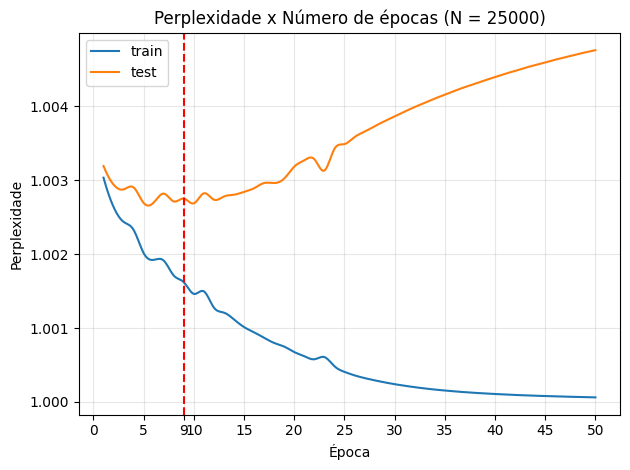

Best accuracy: 85.804


In [ ]:
# This cell is responsible to plotting perplexity changes according to number of epochs.

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

def plot_list_trend(ax, l, label):
    # Create an array representing the index of each data point
    X = np.array([i for i in range(1, len(l) + 1)])
    # Create a spline interpolation function using X and the provided data
    X_Y_Spline = make_interp_spline(X, l)
    # Generate a denser set of X values for smoother plotting
    X_ = np.linspace(X.min(), X.max(), 500)
    # Use the interpolation function to get corresponding Y values
    Y_ = X_Y_Spline(X_)
    # Find the index of the minimum value in the provided data
    min_value_idx = np.argmin(l)
    # Plot the data on the provided axis
    ax.plot(X_, Y_, label=label)
    # Set the label for the x-axis
    ax.set_xlabel("Época")
    # Set the label for the y-axis
    ax.set_ylabel("Perplexidade")
    # Set the title of the plot based on the provided condition
    ax.set_title(f"Perplexidade x Número de épocas (N = {reduced_dataset_size if reduce_dataset else 25000})")
    # Add a legend to the plot
    ax.legend()
    # Add a vertical dashed line at the index of the minimum value for the 'test' data
    if label == 'test':
        ax.axvline(x=min_value_idx, color='r', linestyle='dashed')
    # Add gridlines to the plot with a transparency level of 0.3
    ax.grid(alpha=0.3)
    # Set the x-axis ticks for every 5 units and include the index of the minimum value
    ax.set_xticks([i for i in range(0, 51, 5)] + [min_value_idx])

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1)

# Plot the training and testing data on the same axis
plot_list_trend(ax, np.array(performance_train).transpose()[1], 'train')
plot_list_trend(ax, np.array(performance_test).transpose()[1], 'test')

# Adjust the layout of the plot for better presentation
plt.tight_layout()
# Display the plot
plt.show()

# Find the index of the maximum value in the testing data
max_value_idx = np.argmax(np.array(performance_test).transpose()[0])

# Print the best accuracy value based on the index found
print("Best accuracy:", np.array(performance_test).transpose()[0][max_value_idx])


Epoch [1/5],                 Loss: 0.6924,                 Elapsed Time: 0.18 sec
Epoch [2/5],                 Loss: 0.6924,                 Elapsed Time: 0.17 sec
Epoch [3/5],                 Loss: 0.6924,                 Elapsed Time: 0.18 sec
Epoch [4/5],                 Loss: 0.6924,                 Elapsed Time: 0.17 sec
Epoch [5/5],                 Loss: 0.6924,                 Elapsed Time: 0.17 sec
test Loss: 0.0054
test PPL: 1.0055
test Accuracy: 49.52%
Epoch [1/5],                 Loss: 0.6930,                 Elapsed Time: 0.20 sec
Epoch [2/5],                 Loss: 0.6904,                 Elapsed Time: 0.18 sec
Epoch [3/5],                 Loss: 0.6879,                 Elapsed Time: 0.20 sec
Epoch [4/5],                 Loss: 0.6852,                 Elapsed Time: 0.20 sec
Epoch [5/5],                 Loss: 0.6822,                 Elapsed Time: 0.20 sec
test Loss: 0.0054
test PPL: 1.0054
test Accuracy: 69.316%
Epoch [1/5],                 Loss: 0.6915,                 Elapse

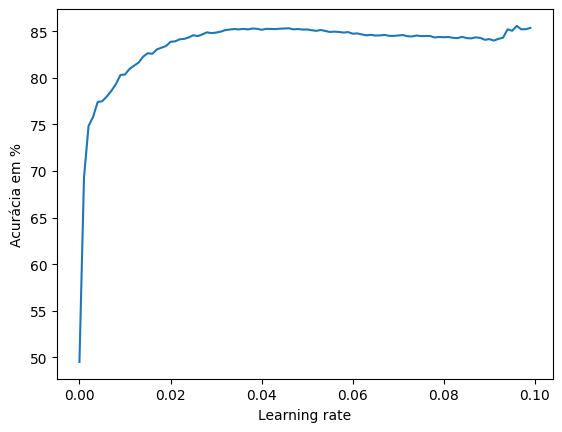

0.096
85.576


In [ ]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1)

# Lists to store learning rates and corresponding accuracies
X_lr = []
Y_lr = []

# Loop through a range of learning rates
for lr in np.arange(0, 0.1, 0.001):
    # Append the learning rate to the X_lr list
    X_lr.append(lr)
    # Train the model with the current learning rate and evaluate its accuracy
    model = train(lr)
    Y_lr.append(eval(model)[0])

# Plot the learning rate versus accuracy
ax.plot(X_lr, Y_lr)

# Set the label for the x-axis
ax.set_xlabel("Learning rate")
# Set the label for the y-axis
ax.set_ylabel("Acurácia em %")

# Display the plot
plt.show()

# Find the learning rate corresponding to the maximum accuracy
max_accuracy_lr = X_lr[np.argmax(Y_lr)]

# Find the maximum accuracy achieved
max_accuracy = max(Y_lr)

# Print the learning rate corresponding to the maximum accuracy and the maximum accuracy
print(max_accuracy_lr)
print(max_accuracy)
